# Lottery ticket hypothesis primer

The objective of this notebook is to provide a primer on how to implement the Lottery Ticket Hypothesis (LTH) algorithm. We will train a small network in keras and use a bunch of methods to prune the net, reinitialize and retrain the subnetwork.

In [1]:
%cd ..

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from src.layers import Linear
from src.pruning import prune, magnitude_saliency_criterion, restore_initial_weights

In [3]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Flatten pixels and convert to float32
X_train = X_train.reshape([X_train.shape[0], -1]).astype(np.float32)
X_test = X_test.reshape([X_test.shape[0], -1]).astype(np.float32)

In [5]:
# Build MLP model
model = tf.keras.models.Sequential([Linear(128),
                                    Linear(128), 
                                    Linear(10, activation=tf.nn.softmax)])

# Compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Initialize
model.build(input_shape=X_train.shape)

In [6]:
# Store a backup of the initial weights
initial_weights_backup = {w.name:w.numpy() for w in model.variables}

## Train the network until convergence 

In [7]:
hist_first_train = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4648 - accuracy: 0.9026 - val_loss: 0.2466 - val_accuracy: 0.9314
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1696 - accuracy: 0.9508 - val_loss: 0.1749 - val_accuracy: 0.9532
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1485 - accuracy: 0.9577 - val_loss: 0.1605 - val_accuracy: 0.9554
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1344 - accuracy: 0.9624 - val_loss: 0.1711 - val_accuracy: 0.9559
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1221 - accuracy: 0.9666 - val_loss: 0.1625 - val_accuracy: 0.9599
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1125 - accuracy: 0.9703 - val_loss: 0.1550 - val_accuracy: 0.9600
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0987 - accuracy: 0.9736 - val_loss: 0.1473 - val_accuracy:

## Prune the network 

In [8]:
prune_proportion = 0.90

In [9]:
model = prune(model, prune_proportion=prune_proportion, criterion=magnitude_saliency_criterion)

In [10]:
# Train accuracy before retraining
model.evaluate(X_train, y_train);
# Test accuracy before retraining
model.evaluate(X_test, y_test);

313/313 [==============================] - 0s 2ms/step - loss: 2.2634 - accuracy: 0.2200


## Finetune the subnetwork achieved [optional]

In [11]:
hist_finetune = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7032 - accuracy: 0.7727 - val_loss: 0.2908 - val_accuracy: 0.9270
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1973 - accuracy: 0.9444 - val_loss: 0.1938 - val_accuracy: 0.9490
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1349 - accuracy: 0.9605 - val_loss: 0.1623 - val_accuracy: 0.9589
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1062 - accuracy: 0.9682 - val_loss: 0.1563 - val_accuracy: 0.9593
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0897 - accuracy: 0.9723 - val_loss: 0.1495 - val_accuracy: 0.9645
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0781 - accuracy: 0.9762 - val_loss: 0.1464 - val_accuracy: 0.9623
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0685 - accuracy: 0.9789 - val_loss: 0.1406 - val_accuracy:

In [12]:
# Train accuracy after retraining
model.evaluate(X_train, y_train);
# Test accuracy after retraining
model.evaluate(X_test, y_test);

313/313 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.9640


In [13]:
# Check the percentage of zero weights
for w in model.variables:
    print (f"Parameter {w.name} contains {(w.numpy()==0).mean()*100}% null connections")

Parameter linear/Variable:0 contains 90.00019929846938% null connections
Parameter linear/Variable:0_b:0 contains 0.0% null connections
Parameter linear/Variable:0_m:0 contains 90.00019929846938% null connections
Parameter linear_1/Variable:0 contains 90.00244140625% null connections
Parameter linear_1/Variable:0_b:0 contains 0.0% null connections
Parameter linear_1/Variable:0_m:0 contains 90.00244140625% null connections
Parameter linear_2/Variable:0 contains 90.0% null connections
Parameter linear_2/Variable:0_b:0 contains 0.0% null connections
Parameter linear_2/Variable:0_m:0 contains 90.0% null connections


## Reinitialize and train the subnetwork

In [14]:
model = restore_initial_weights(model, initial_weights_backup)

In [15]:
# Train accuracy after restoring initial weights
model.evaluate(X_train, y_train);
# Test accuracy after restoring initial weights
model.evaluate(X_test, y_test);

313/313 [==============================] - 0s 1ms/step - loss: 2.7662 - accuracy: 0.0896


In [16]:
hist_retrain = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2817 - accuracy: 0.9152 - val_loss: 0.1469 - val_accuracy: 0.9561
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1247 - accuracy: 0.9629 - val_loss: 0.1224 - val_accuracy: 0.9645
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0997 - accuracy: 0.9703 - val_loss: 0.1061 - val_accuracy: 0.9683
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0825 - accuracy: 0.9744 - val_loss: 0.1094 - val_accuracy: 0.9682
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0714 - accuracy: 0.9777 - val_loss: 0.1220 - val_accuracy: 0.9656
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0668 - accuracy: 0.9789 - val_loss: 0.1148 - val_accuracy: 0.9686
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 0.1201 - val_accuracy:

In [17]:
# Train accuracy after retraining from initial weights
model.evaluate(X_train, y_train);
# Test accuracy after retraining from initial weights
model.evaluate(X_test, y_test);

313/313 [==============================] - 0s 1ms/step - loss: 0.1249 - accuracy: 0.9684


In [18]:
# Check the percentage of zero weights
for w in model.variables:
    print (f"Parameter {w.name} contains {(w.numpy()==0).mean()*100}% null connections")

Parameter linear/Variable:0 contains 90.00019929846938% null connections
Parameter linear/Variable:0_b:0 contains 0.0% null connections
Parameter linear/Variable:0_m:0 contains 90.00019929846938% null connections
Parameter linear_1/Variable:0 contains 90.00244140625% null connections
Parameter linear_1/Variable:0_b:0 contains 0.0% null connections
Parameter linear_1/Variable:0_m:0 contains 90.00244140625% null connections
Parameter linear_2/Variable:0 contains 90.0% null connections
Parameter linear_2/Variable:0_b:0 contains 0.0% null connections
Parameter linear_2/Variable:0_m:0 contains 90.0% null connections


## Results

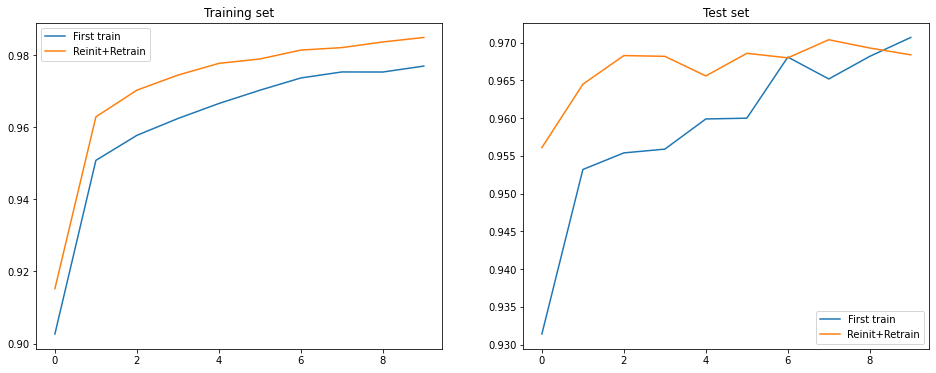

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(hist_first_train.history["accuracy"])
ax1.plot(hist_retrain.history["accuracy"])
ax1.legend(["First train", "Reinit+Retrain"])
ax1.set_title("Training set")

ax2.plot(hist_first_train.history["val_accuracy"])
ax2.plot(hist_retrain.history["val_accuracy"])
ax2.legend(["First train", "Reinit+Retrain"])
ax2.set_title("Test set")

plt.show()